In [ ]:
import os
import numpy as np
from PIL import Image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='darkgrid')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#압축풀기
import zipfile

local_zip = '/content/drive/MyDrive/데이터저장/인간vs애니vs동물.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('/content/human')
zip_ref.close()

In [ ]:
base_dir='/content/human'

train_dir='/content/human/train'
test_dir='/content/human/test'

In [ ]:
train_animal=os.path.join(train_dir,'animal')
train_anime=os.path.join(train_dir,'anime')
train_human=os.path.join(train_dir,'human')

In [ ]:
test_animal=os.path.join(test_dir,'animal')
test_anime=os.path.join(test_dir,'anime')
test_human=os.path.join(test_dir,'human')

In [ ]:
list1=os.listdir(train_animal)
list2=os.listdir(train_anime)
list3=os.listdir(train_human)

In [ ]:
print(len(list1))
print(len(list2))
print(len(list3))

14630
85060
30904


In [ ]:
14630+85060+30904

130594

# 데이터전처리

In [ ]:
batch=32
img_height=250
img_width=250

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator #과적합 문제를 해결하는 전처리 기법 데이터 증가시켜줌

#이미지 ImageDataGenerator를 이용해 이미지 값 rescale과 데이터 양 증가시켜주는 객체 생성
train_datagen= ImageDataGenerator(rescale=1./255, #값을 255로 나누어 0~1사이로 변경
                                  rotation_range=30, # 무작위로 30도 각도 이내로 회전 
                                  shear_range=0.3, #층밀리기 강도 30% 이미지를 어긋나 보이게함
                                  zoom_range=0.3 # 무작위로 줌 범위 30#
                                  )
val_datagen=ImageDataGenerator(rescale=1./255) 

#이미지 변형 시켜주기
train_generator=train_datagen.flow_from_directory(train_dir,
                                                  batch_size=batch, 
                                                  class_mode='sparse', #output 분류 
                                                  target_size=(img_width,img_height) #이미지 사이즈
                                                  )
val_generator=val_datagen.flow_from_directory(test_dir,
                                              batch_size=batch,
                                              class_mode='sparse',
                                              target_size=(img_width,img_height)
                                              )
#flow_from_directory는 이미지를 불러올 때 폴더명에 맞춰서 자동으로 labeling 하는 함수
#flow_from_directory는 디렉토리에의 경로를 전달받아 증강된 데이터의 배치를 생성합니다

Found 130594 images belonging to 3 classes.
Found 13541 images belonging to 3 classes.


In [ ]:
#각각의 값 
print(train_generator.class_indices.items())

print(val_generator.class_indices.items())

dict_items([('animal', 0), ('anime', 1), ('human', 2)])
dict_items([('animal', 0), ('anime', 1), ('human', 2)])


# 모델만들기

In [ ]:
import tensorflow as tf

tf.__version__

from tensorflow.keras import datasets, layers, models
from keras.preprocessing import image
from keras.engine.sequential import Sequential
from tensorflow import keras
from keras import regularizers

In [ ]:
kernel_s=(3,3) 

model=models.Sequential() #딥러닝의 뼈대같은 역할?

model.add(layers.Conv2D(32,kernel_s,activation='relu',input_shape=(img_height,img_width,3),
                        kernel_regularizer=regularizers.l2(0.001),padding="VALID")) # padding valid는 기존 그대로
#conv2D 2차원 배열의 데이터 (32개의 필터 개수, 필터의 크기는 3*3, 활성화 함수 relu, 입력 형태 250,250,3,)
#, regularizer는 최적화 과정 중에 각 층별 파라미터 또는 출력값에 대하여 페널티를 적용할 수 있게 해줌 
#이러한 페널티는 네트워크가 최적화 하련느 손실 함수의 일부로 포함된다.
#l2 가중치의 제곱에 비례하는 cost가 추가됨
#l2(0.001) 가중치 행렬의 모든 원소를 제곱하는 0.001을 곱하여 네트워크의 전체 손실에 더해진다는 의미
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(64, kernel_s, activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, kernel_s, activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(128,kernel_s,activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128,kernel_s,activation='relu'))
model.add(layers.MaxPooling2D((2,2)))


model.add(layers.Flatten()) # 1차원의 벡터 형태로 바꿔줌
model.add(layers.Dense(256,activation='relu')) # 노드들의 개수에 따라 노드들을 연결해줌 총 노드 256개
model.add(layers.Dropout(0.4)) #hidden에 유닛의 일부가 동작되지 않게 하는 방법 40% 동작 x
model.add(layers.Dense(128,activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(3,activation='softmax'))#분류는 softmax사용
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 248, 248, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 124, 124, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 122, 122, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 61, 61, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 59, 59, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 29, 29, 64)       0

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics='accuracy'
              )

# 학습하기

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

earlystopping=EarlyStopping(monitor='val_loss', #val_loss 값이 개선되었을 때
                            patience=5 #5회 epoch 동안 val_loss가 개선되지 않는다면 종료
                            )

history=model.fit(train_generator,
                  epochs=5,
                  steps_per_epoch=100,
                  validation_data=val_generator,
                  callbacks=[earlystopping] # 설정한 epoch동안 val_loss가 개선되지 않으면 학습 종료
                  )

Epoch 1/5
100/100 [==============================] - 84s 752ms/step - loss: 0.5675 - accuracy: 0.7725 - val_loss: 0.1566 - val_accuracy: 0.9561
Epoch 2/5
100/100 [==============================] - 70s 703ms/step - loss: 0.2065 - accuracy: 0.9316 - val_loss: 0.1474 - val_accuracy: 0.9575
Epoch 3/5
100/100 [==============================] - 72s 721ms/step - loss: 0.1236 - accuracy: 0.9616 - val_loss: 0.0833 - val_accuracy: 0.9750
Epoch 4/5
100/100 [==============================] - 70s 699ms/step - loss: 0.1374 - accuracy: 0.9600 - val_loss: 0.0744 - val_accuracy: 0.9752
Epoch 5/5
100/100 [==============================] - 77s 771ms/step - loss: 0.0965 - accuracy: 0.9725 - val_loss: 0.0389 - val_accuracy: 0.9899


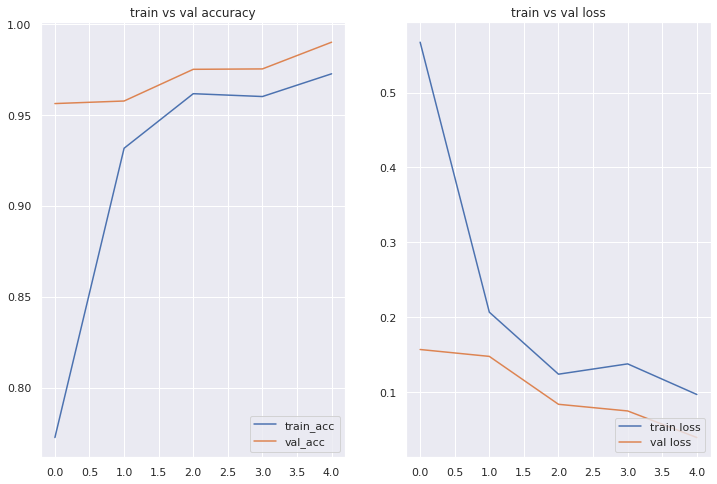

In [ ]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range=range(5)

plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='train_acc')
plt.plot(epochs_range, val_acc, label='val_acc')
plt.legend(loc='lower right')
plt.title('train vs val accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label='train loss')
plt.plot(epochs_range, val_loss, label='val loss')
plt.title('train vs val loss')

plt.show()

In [ ]:
#모델 저장하기
from keras.models import load_model
model.save('애니vs인간vs동물.h5')

# 모델 불러오기

In [ ]:
from keras.models import load_model
model = load_model('/content/drive/MyDrive/데이터저장/모델저장/애니vs인간vs동물.h5')

In [ ]:
#test데이터 정확도 확인
test_loss, test_acc = model.evaluate(val_generator,verbose=2)#verbose는 그냥 출력문을 어떤식으로 보여줄까 묻는거 0은 출력문 안보여줌 1은 반만 2는 전체 다 출력

print('\n테스트 정확도:', test_acc)
print('\n테스트 손실값"',test_loss)

424/424 - 39s - loss: 0.0389 - accuracy: 0.9899 - 39s/epoch - 93ms/step

테스트 정확도: 0.9898825883865356

테스트 손실값" 0.03890318050980568


# 시각화

In [ ]:
import cv2
import glob

test_img_list=[]

test_img_name_list=glob.glob('테스트용/*')

for i in range(len(test_img_name_list)):
    src_img = cv2.imread(test_img_name_list[i], cv2.IMREAD_COLOR)
    src_img = cv2.resize(src_img, dsize=(img_width, img_height))
    src_img = cv2.cvtColor(src_img, cv2.COLOR_BGR2RGB)
    src_img = src_img / 255.0

    test_img_list.append(src_img)

1/1 [==============================] - 0s 24ms/step


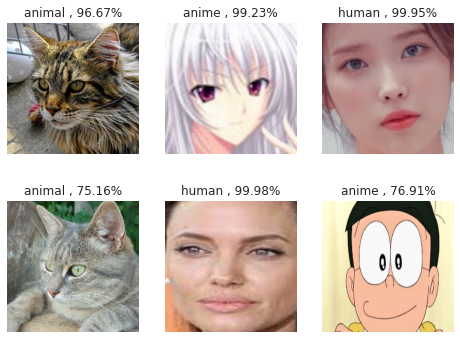

In [ ]:
pred=model.predict(np.array(test_img_list))

name=['animal','anime','human']

plt.figure(figsize=(8,6))

for i in range(len(test_img_list)):
  plt.subplot(2,3,i+1)
  prediction=str(name[np.argmax(pred[i])])
  prob='{0:0.2f}'.format(100*max(pred[i]))
  title_str=prediction+' , '+prob+'%'
  plt.title(title_str)

  plt.imshow(test_img_list[i])
  plt.axis('off')
plt.show()